**Definition**

Time series: a series of data points indexed in time order.

<br/> 


 

Classically, there are two main approaches (not mutually exclusive) in time series analysis:



*   Time domain approach: focus on investigation of lagged relationships (e.g., how does what happened today affect what will happen tomorrow)


*   Frequency domain approach: focus on investigation of cycles (e.g., what is the economic cycle through periods of expansion and recession).


We will mainly address time domain approach in the course.


# 1.1 The Nature of Time Series Data

In [13]:
#install.packages("caret") 
#install.packages("mice") 
#install.packages("VIM") 
#install.packages("glmnet") 
#install.packages("pROC") 
#install.packages("xgboost") 
#install.packages("pdp") 
#install.packages("car") 
#install.packages("SHAPforxgboost") 

In [14]:
library(tidyverse) 
library(caret) #for Data splitting
library(mice)
library(VIM) #for plot missing data patterns
library(glmnet) # for lasso and ridge regularization
library(pROC) #For AUC calculation
library(xgboost) 
library(pdp) #for PCA
library(car) # for VIF
library(SHAPforxgboost) # for shapley value

In [41]:
getwd()

[1] "/content"

ERROR: ignored

In [45]:
# R studio version: 2022.02.3
#######################################################################
#                                                                     #
#                          Load the data                              #
#                                                                     #
#######################################################################
df <- read_csv("/content/Training.csv")
test <- read_csv("/content/Test.csv")

Rows: 20000 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): rep_education
dbl (20): tot_balance, avg_bal_cards, credit_age, credit_age_good_account, c...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 5000 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): rep_education
dbl (20): tot_balance, avg_bal_cards, credit_age, credit_age_good_account, c...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [46]:
#######################################################################
#                                                                     #
#                          Split the data                             #
#                                                                     #
#######################################################################

set.seed(1)
training.samples <- df$Def_ind %>% createDataPartition(p = 0.8, list = FALSE)
train <- df[training.samples, ] # training set
val <- df[-training.samples, ] # validation set
dim(train)
dim(val)
colnames(train)
# Remove name space: num_auto_ 36_month
colnames(train)[13] <- "num_auto_36_month"
colnames(val)[13] <- "num_auto_36_month"
colnames(test)[13] <- "num_auto_36_month"

attach(train)

[1] 16000    21

[1] 4000   21

[1] "tot_balance"                     "avg_bal_cards"                  
 [3] "credit_age"                      "credit_age_good_account"        
 [5] "credit_card_age"                 "num_acc_30d_past_due_12_months" 
 [7] "num_acc_30d_past_due_6_months"   "num_mortgage_currently_past_due"
 [9] "tot_amount_currently_past_due"   "num_inq_12_month"               
[11] "num_card_inq_24_month"           "num_card_12_month"              
[13] "num_auto_ 36_month"              "uti_open_card"                  
[15] "pct_over_50_uti"                 "uti_max_credit_line"            
[17] "pct_card_over_50_uti"            "ind_XYZ"                        
[19] "rep_income"                      "rep_education"                  
[21] "Def_ind"

In [47]:
# Data summary 
trainc <- train # create a copy 
trainc$num_acc_30d_past_due_12_months<-factor(trainc$num_acc_30d_past_due_12_months)
trainc$num_acc_30d_past_due_6_months<-factor(trainc$num_acc_30d_past_due_6_months)
trainc$ num_mortgage_currently_past_due<-factor(trainc$num_mortgage_currently_past_due)
trainc$num_card_12_month <-factor(trainc$num_card_12_month)
trainc$num_auto_36_month <-factor(trainc$num_auto_36_month)
trainc$ind_XYZ <-factor(trainc$ind_XYZ)
trainc$rep_education <- factor(trainc$rep_education)
trainc$Def_ind <-factor(trainc$Def_ind)

trainc_x_continuous <- trainc[,c(1,2,3,4,5,9,10,11,14,15,16,17,19)]
summary(trainc_x_continuous) # statistics for continuous variables
apply(trainc_x_continuous, 2, sd, na.rm =TRUE) # 2: by columns
summary(trainc[,-c(1,2,3,4,5,9,10,11,14,15,16,17,19)]) # frequency count for categorical variables

  tot_balance     avg_bal_cards     credit_age    credit_age_good_account
 Min.   :     0   Min.   :    0   Min.   :  0.0   Min.   :  0.0          
 1st Qu.: 92216   1st Qu.:10171   1st Qu.:232.0   1st Qu.:120.0          
 Median :107620   Median :12253   Median :281.0   Median :146.0          
 Mean   :107360   Mean   :12234   Mean   :280.8   Mean   :146.1          
 3rd Qu.:122635   3rd Qu.:14271   3rd Qu.:330.0   3rd Qu.:172.0          
 Max.   :200000   Max.   :25000   Max.   :550.0   Max.   :300.0          
                                                                         
 credit_card_age tot_amount_currently_past_due num_inq_12_month
 Min.   :  0.0   Min.   :    0.0               Min.   : 0.000  
 1st Qu.:242.0   1st Qu.:    0.0               1st Qu.: 0.000  
 Median :285.0   Median :    0.0               Median : 0.000  
 Mean   :285.3   Mean   :  359.5               Mean   : 0.612  
 3rd Qu.:330.0   3rd Qu.:    0.0               3rd Qu.: 1.000  
 Max.   :524.0   Max.   

tot_balance                 avg_bal_cards 
                 2.233971e+04                  3.058643e+03 
                   credit_age       credit_age_good_account 
                 7.297416e+01                  3.850411e+01 
              credit_card_age tot_amount_currently_past_due 
                 6.393024e+01                  1.783096e+03 
             num_inq_12_month         num_card_inq_24_month 
                 1.157385e+00                  2.032479e+00 
                uti_open_card               pct_over_50_uti 
                 1.297574e-01                  1.226466e-01 
          uti_max_credit_line          pct_card_over_50_uti 
                 1.313057e-01                  1.285394e-01 
                   rep_income 
                 3.339831e+04

 num_acc_30d_past_due_12_months num_acc_30d_past_due_6_months
 0:14058                        0:15531                      
 1: 1429                        1:  451                      
 2:  431                        2:   18                      
 3:   74                                                     
 4:    6                                                     
 5:    2                                                     
 num_mortgage_currently_past_due num_card_12_month num_auto_36_month ind_XYZ  
 0:15505                         0:11922           0:13417           0:11992  
 1:  495                         1: 3778           1: 2546           1: 4008  
                                 2:  294           2:   37                    
                                 3:    6                                      
                                                                              
                                                                              
     rep_educ

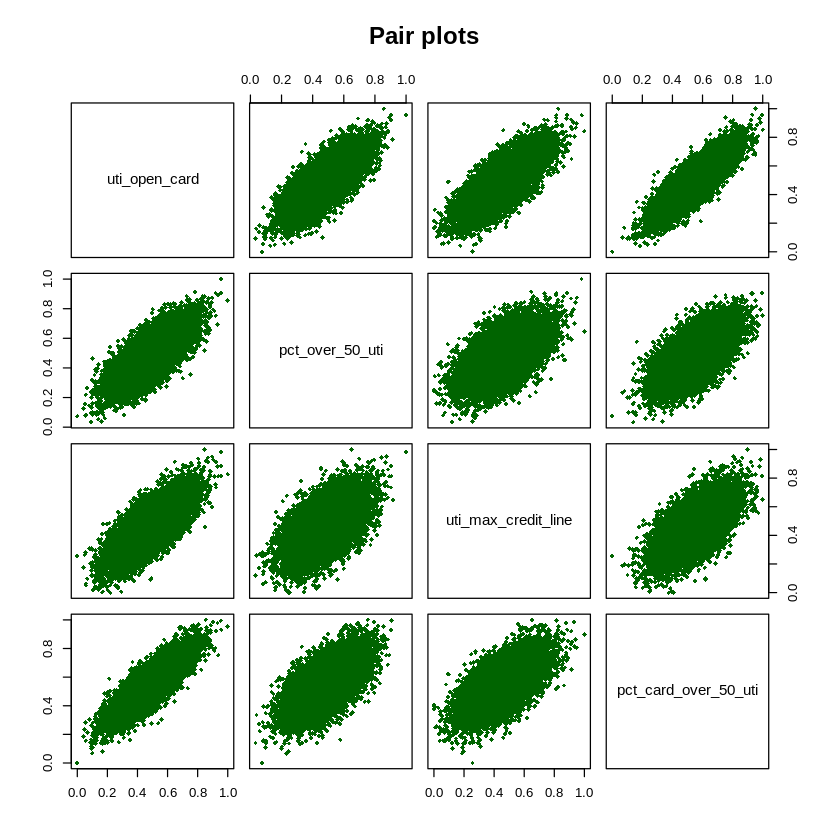

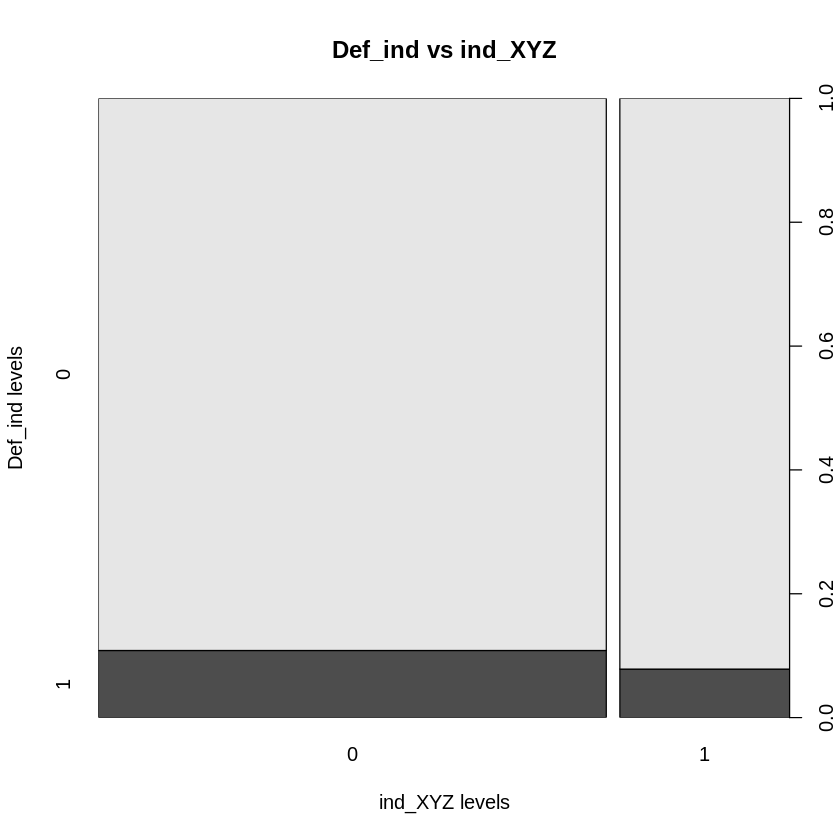

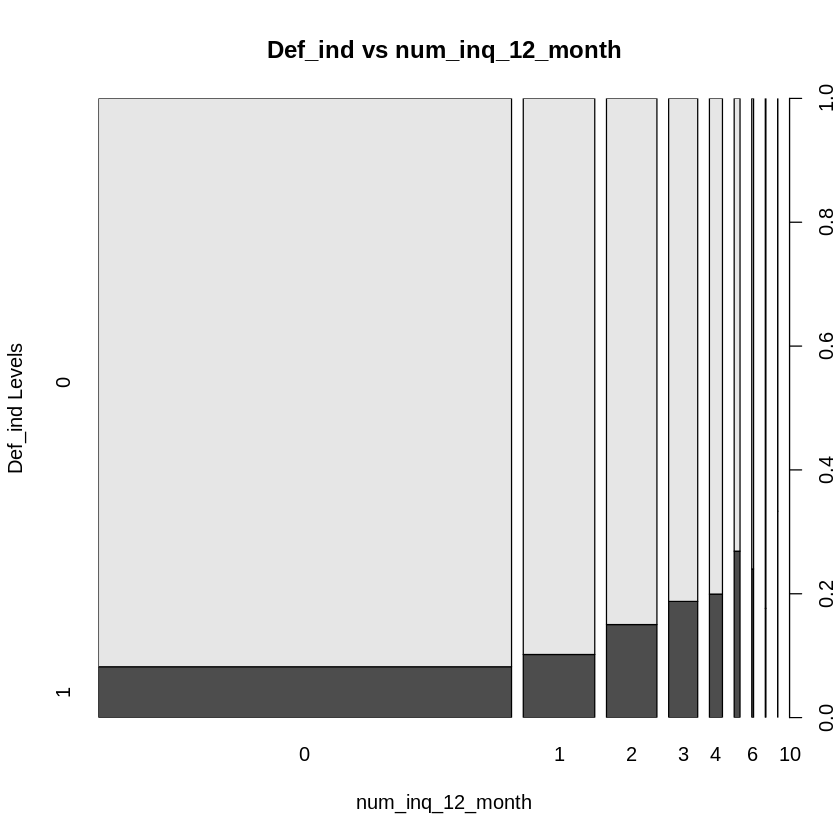

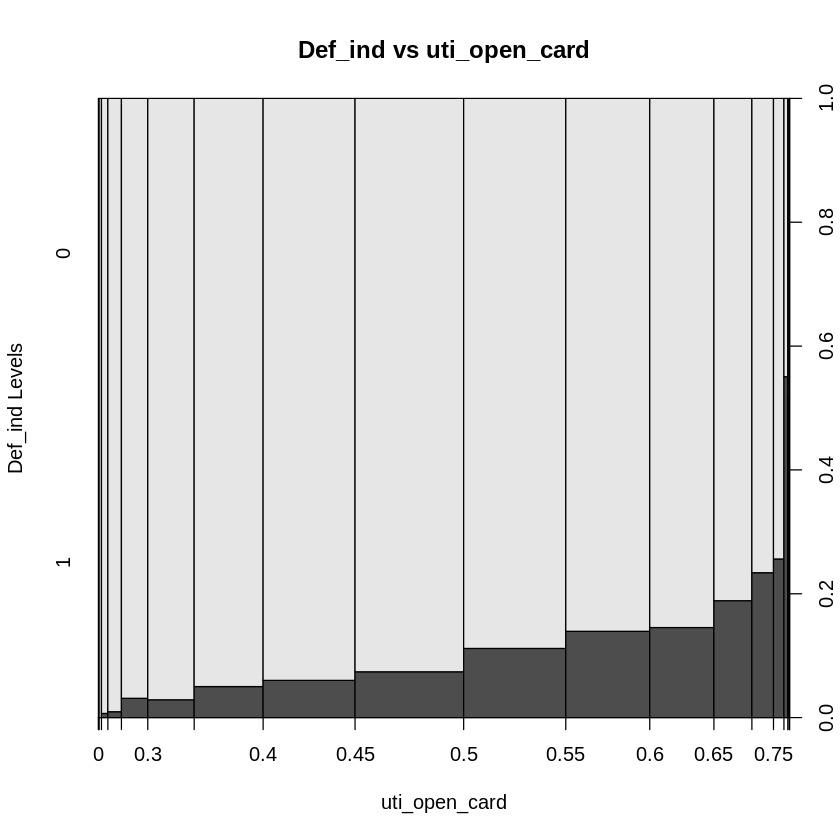

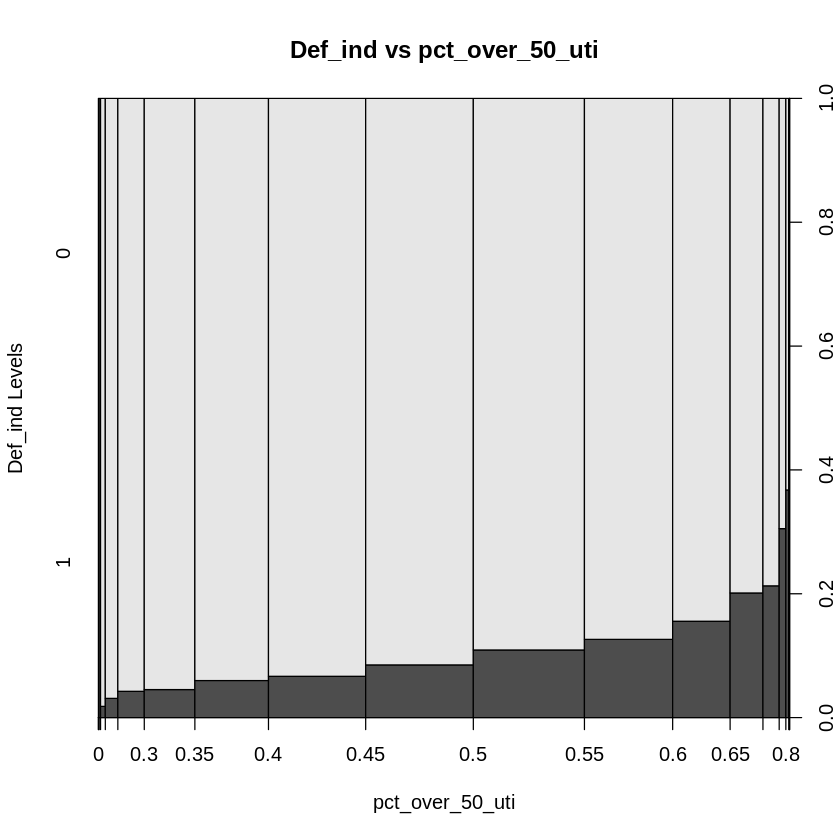

In [48]:
# Data exploration
pairs(train[,c(14, 15, 16, 17)], cex = 0.8, col = "darkgreen",pch = 18, 
      main = " Pair plots")

plot(factor(Def_ind) ~ factor(ind_XYZ), data =train, 
     ylab="Def_ind levels",xlab="ind_XYZ levels", main="Def_ind vs ind_XYZ")

plot(factor(Def_ind) ~ factor(num_inq_12_month), data =train,
     xlab = 'num_inq_12_month', ylab ='Def_ind Levels',main="Def_ind vs num_inq_12_month")

plot(factor(Def_ind) ~ uti_open_card, data =train, 
     xlab = 'uti_open_card', ylab ='Def_ind Levels',main="Def_ind vs uti_open_card")

plot( factor(Def_ind) ~ (pct_over_50_uti), data =train,
      xlab = 'pct_over_50_uti', ylab ='Def_ind Levels',main="Def_ind vs pct_over_50_uti")

pct_card_over_50_uti                      rep_income 
                        9.75625                         7.75000 
                    tot_balance                   avg_bal_cards 
                        0.00000                         0.00000 
                     credit_age         credit_age_good_account 
                        0.00000                         0.00000 
                credit_card_age  num_acc_30d_past_due_12_months 
                        0.00000                         0.00000 
  num_acc_30d_past_due_6_months num_mortgage_currently_past_due 
                        0.00000                         0.00000 
  tot_amount_currently_past_due                num_inq_12_month 
                        0.00000                         0.00000 
          num_card_inq_24_month               num_card_12_month 
                        0.00000                         0.00000 
              num_auto_36_month                   uti_open_card 
                        0.00000                         0.00000 
                pct_over_50_uti             uti_max_credit_line 
                        0.00000                         0.00000 
                        ind_XYZ                   rep_education 
                        0.00000                         0.00000 
                        Def_ind 
                        0.00000

pct_card_over_50_uti                      rep_income 
                          9.925                           7.975 
                  rep_education                     tot_balance 
                          0.025                           0.000 
                  avg_bal_cards                      credit_age 
                          0.000                           0.000 
        credit_age_good_account                 credit_card_age 
                          0.000                           0.000 
 num_acc_30d_past_due_12_months   num_acc_30d_past_due_6_months 
                          0.000                           0.000 
num_mortgage_currently_past_due   tot_amount_currently_past_due 
                          0.000                           0.000 
               num_inq_12_month           num_card_inq_24_month 
                          0.000                           0.000 
              num_card_12_month               num_auto_36_month 
                          0.000                           0.000 
                  uti_open_card                 pct_over_50_uti 
                          0.000                           0.000 
            uti_max_credit_line                         ind_XYZ 
                          0.000                           0.000 
                        Def_ind 
                          0.000

pct_card_over_50_uti                      rep_income 
                           9.78                            8.20 
                  rep_education                     tot_balance 
                           0.08                            0.00 
                  avg_bal_cards                      credit_age 
                           0.00                            0.00 
        credit_age_good_account                 credit_card_age 
                           0.00                            0.00 
 num_acc_30d_past_due_12_months   num_acc_30d_past_due_6_months 
                           0.00                            0.00 
num_mortgage_currently_past_due   tot_amount_currently_past_due 
                           0.00                            0.00 
               num_inq_12_month           num_card_inq_24_month 
                           0.00                            0.00 
              num_card_12_month               num_auto_36_month 
                           0.00                            0.00 
                  uti_open_card                 pct_over_50_uti 
                           0.00                            0.00 
            uti_max_credit_line                         ind_XYZ 
                           0.00                            0.00 
                        Def_ind 
                           0.00

pct_card_over_50_uti                      rep_income 
                           1561                            1240 
                    tot_balance                   avg_bal_cards 
                              0                               0 
                     credit_age         credit_age_good_account 
                              0                               0 
                credit_card_age  num_acc_30d_past_due_12_months 
                              0                               0 
  num_acc_30d_past_due_6_months num_mortgage_currently_past_due 
                              0                               0 
  tot_amount_currently_past_due                num_inq_12_month 
                              0                               0 
          num_card_inq_24_month               num_card_12_month 
                              0                               0 
              num_auto_36_month                   uti_open_card 
                              0                               0 
                pct_over_50_uti             uti_max_credit_line 
                              0                               0 
                        ind_XYZ                   rep_education 
                              0                               0 
                        Def_ind 
                              0

pct_card_over_50_uti                      rep_income 
                            397                             319 
                  rep_education                     tot_balance 
                              1                               0 
                  avg_bal_cards                      credit_age 
                              0                               0 
        credit_age_good_account                 credit_card_age 
                              0                               0 
 num_acc_30d_past_due_12_months   num_acc_30d_past_due_6_months 
                              0                               0 
num_mortgage_currently_past_due   tot_amount_currently_past_due 
                              0                               0 
               num_inq_12_month           num_card_inq_24_month 
                              0                               0 
              num_card_12_month               num_auto_36_month 
                              0                               0 
                  uti_open_card                 pct_over_50_uti 
                              0                               0 
            uti_max_credit_line                         ind_XYZ 
                              0                               0 
                        Def_ind 
                              0

pct_card_over_50_uti                      rep_income 
                            489                             410 
                  rep_education                     tot_balance 
                              4                               0 
                  avg_bal_cards                      credit_age 
                              0                               0 
        credit_age_good_account                 credit_card_age 
                              0                               0 
 num_acc_30d_past_due_12_months   num_acc_30d_past_due_6_months 
                              0                               0 
num_mortgage_currently_past_due   tot_amount_currently_past_due 
                              0                               0 
               num_inq_12_month           num_card_inq_24_month 
                              0                               0 
              num_card_12_month               num_auto_36_month 
                              0                               0 
                  uti_open_card                 pct_over_50_uti 
                              0                               0 
            uti_max_credit_line                         ind_XYZ 
                              0                               0 
                        Def_ind 
                              0


 Variables sorted by number of missings: 
             Variable     Count
 pct_card_over_50_uti 0.0975625
           rep_income 0.0775000


Warning message in plot.aggr(res, ...):
“not enough horizontal space to display frequencies”


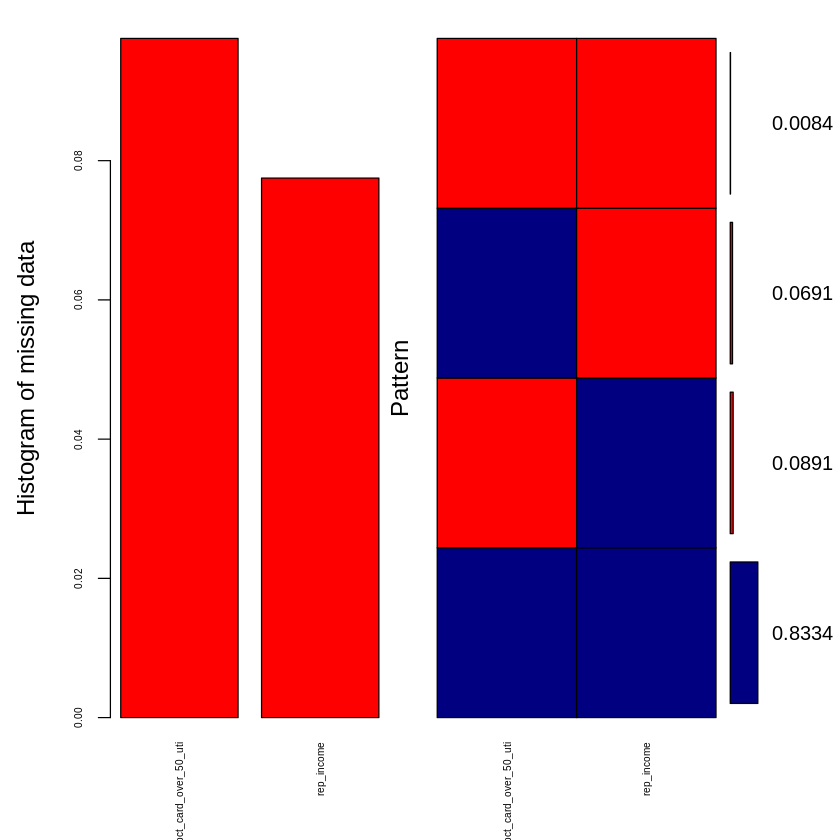


 Variables sorted by number of missings: 
             Variable   Count
 pct_card_over_50_uti 0.09925
           rep_income 0.07975
        rep_education 0.00025


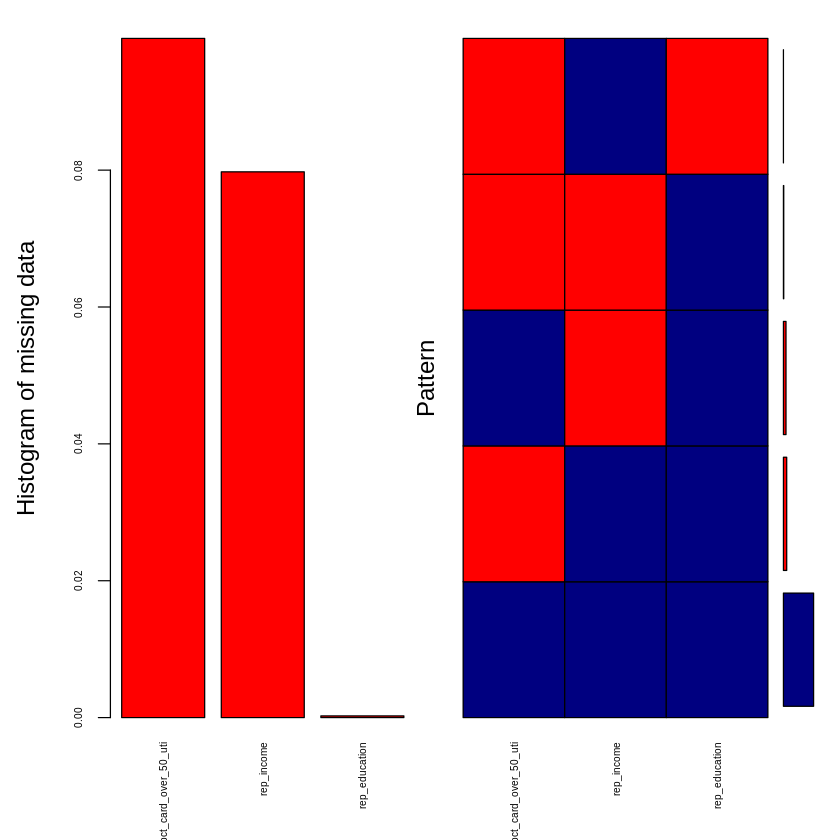


 Variables sorted by number of missings: 
             Variable  Count
 pct_card_over_50_uti 0.0978
           rep_income 0.0820
        rep_education 0.0008


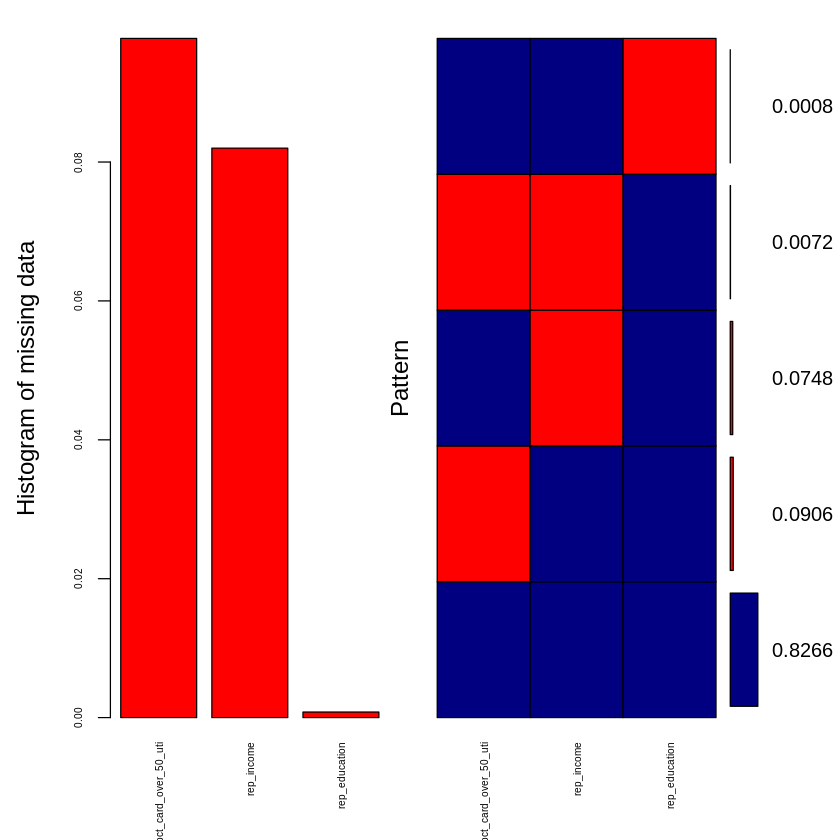

In [49]:
#######################################################################
#                                                                     #
#                           Data cleaning                             #
#                                                                     #
#######################################################################

# Missing data percent and count
pMiss <- function(x){
  sum(is.na(x))/length(x)*100
}

(miss_tr <- sort(apply(train,2,pMiss) ,decreasing =TRUE)) #missing percentages
(miss_val <- sort(apply(val,2,pMiss), decreasing =TRUE))
(miss_ts <- sort(apply(test,2,pMiss), decreasing =TRUE)) 
dim(train)[1]*miss_tr/100 #missing counts
dim(val)[1]*miss_val/100
dim(test)[1]*miss_ts/100

# Missing data plots
aggr(train[which(apply(train,2,pMiss)>0)], col=c('navyblue','red'), numbers=TRUE, sortVars=TRUE, 
     labels=names(train[which(apply(train,2,pMiss)>0)]), cex.axis=0.5, gap=2, 
     ylab=c("Histogram of missing data","Pattern"))
aggr(val[which(apply(val,2,pMiss)>0)], col=c('navyblue','red'), numbers=TRUE, sortVars=TRUE, 
     labels=names(val[which(apply(val,2,pMiss)>0)]), cex.axis=0.5, gap=2, 
     ylab=c("Histogram of missing data","Pattern"))
aggr(test[which(apply(test,2,pMiss)>0)], col=c('navyblue','red'), numbers=TRUE, sortVars=TRUE, 
     labels=names(test[which(apply(test,2,pMiss)>0)]), cex.axis=0.5, gap=2, 
     ylab=c("Histogram of missing data","Pattern"))

In [50]:
# Impute missing data
# Exclude categorical variables and y
train2 <- subset(train, select = -c(rep_education, ind_XYZ,Def_ind))
val2 <- subset(val, select = -c(rep_education, ind_XYZ,Def_ind))
test2 <- subset(test, select = -c(rep_education, ind_XYZ,Def_ind))

# impute continuous data - training set
tempData <- mice(train2,m=5,maxit=50,meth='pmm',seed=500)
completedData <- complete(tempData,1)
train3<-as_tibble(cbind(completedData,train[, which(names(train) %in% 
                              c('rep_education', 'ind_XYZ','Def_ind'))]))

# categorical- training set, impute with mode
which.max(table(train3$rep_education))
train3$rep_education[is.na(train3$rep_education)] <- "college"

# define X and Y - training
train3$ind_XYZ  <- factor(train3$ind_XYZ)
X_train =  train3[,-21]
y_train = train3$Def_ind

# impute continuous data - validation set
tempData_val <- mice(val2,m=5,maxit=50,meth='pmm',seed=500)
completedData <- complete(tempData_val,1)
val3<-as_tibble(cbind(completedData,val[, which(names(val) %in% 
                                                  c('rep_education', 'ind_XYZ','Def_ind'))]))

# define X and y - validation
val3$ind_XYZ  <- factor(val3$ind_XYZ)
X_val =  val3[,-21]
y_val = val3$Def_ind

# impute continuous data - testing set
tempData <- mice(test2,m=5,maxit=50,meth='pmm',seed=500)
completedData <- complete(tempData,1)
test3<-as_tibble(cbind(completedData,test[, which(names(test) %in% 
                                                    c('rep_education', 'ind_XYZ','Def_ind'))]))

# categorical, replace with mode
which.max(table(test3$rep_education))
test3$rep_education[is.na(test3$rep_education)] <- "high_school"

# define X and y - testing
test3$ind_XYZ  <- factor(test3$ind_XYZ)
X_test =  test3[,-21]
y_test = test3$Def_ind


 iter imp variable
  1   1  pct_card_over_50_uti  rep_income
  1   2  pct_card_over_50_uti  rep_income
  1   3  pct_card_over_50_uti  rep_income
  1   4  pct_card_over_50_uti  rep_income
  1   5  pct_card_over_50_uti  rep_income
  2   1  pct_card_over_50_uti  rep_income
  2   2  pct_card_over_50_uti  rep_income
  2   3  pct_card_over_50_uti  rep_income
  2   4  pct_card_over_50_uti  rep_income
  2   5  pct_card_over_50_uti  rep_income
  3   1  pct_card_over_50_uti  rep_income
  3   2  pct_card_over_50_uti  rep_income
  3   3  pct_card_over_50_uti  rep_income
  3   4  pct_card_over_50_uti  rep_income
  3   5  pct_card_over_50_uti  rep_income
  4   1  pct_card_over_50_uti  rep_income
  4   2  pct_card_over_50_uti  rep_income
  4   3  pct_card_over_50_uti  rep_income
  4   4  pct_card_over_50_uti  rep_income
  4   5  pct_card_over_50_uti  rep_income
  5   1  pct_card_over_50_uti  rep_income
  5   2  pct_card_over_50_uti  rep_income
  5   3  pct_card_over_50_uti  rep_income
  5   4  pct_c

college 
      1


 iter imp variable
  1   1  pct_card_over_50_uti  rep_income
  1   2  pct_card_over_50_uti  rep_income
  1   3  pct_card_over_50_uti  rep_income
  1   4  pct_card_over_50_uti  rep_income
  1   5  pct_card_over_50_uti  rep_income
  2   1  pct_card_over_50_uti  rep_income
  2   2  pct_card_over_50_uti  rep_income
  2   3  pct_card_over_50_uti  rep_income
  2   4  pct_card_over_50_uti  rep_income
  2   5  pct_card_over_50_uti  rep_income
  3   1  pct_card_over_50_uti  rep_income
  3   2  pct_card_over_50_uti  rep_income
  3   3  pct_card_over_50_uti  rep_income
  3   4  pct_card_over_50_uti  rep_income
  3   5  pct_card_over_50_uti  rep_income
  4   1  pct_card_over_50_uti  rep_income
  4   2  pct_card_over_50_uti  rep_income
  4   3  pct_card_over_50_uti  rep_income
  4   4  pct_card_over_50_uti  rep_income
  4   5  pct_card_over_50_uti  rep_income
  5   1  pct_card_over_50_uti  rep_income
  5   2  pct_card_over_50_uti  rep_income
  5   3  pct_card_over_50_uti  rep_income
  5   4  pct_c

high_school 
          3

In [53]:
#######################################################################
#                                                                     #
#                          Check multicollinearity                    #
#                                                                     #
#######################################################################

X_trainc <- subset(X_train, select = -c(rep_education, ind_XYZ)) # keep continuous x variables

# check VIFs
# x <- as.matrix(X_trainc)
VIF = diag(solve(cor(X_trainc))); VIF # <10 # diagonal terms of inverse(correlation(X))

# Check condition number (values need to be scaled)
scale.x = scale(X_trainc)
e = eigen(t(scale.x)%*%scale.x)
sqrt(max(e$values)/min(e$values)) #<30, no serious multi-collinearity problem


tot_balance                   avg_bal_cards 
                       1.987193                        1.986246 
                     credit_age         credit_age_good_account 
                       5.397348                        2.743174 
                credit_card_age  num_acc_30d_past_due_12_months 
                       3.597421                        3.188927 
  num_acc_30d_past_due_6_months num_mortgage_currently_past_due 
                       3.049310                        3.026203 
  tot_amount_currently_past_due                num_inq_12_month 
                       4.120346                        5.421359 
          num_card_inq_24_month               num_card_12_month 
                       5.416052                        1.015891 
              num_auto_36_month                   uti_open_card 
                       1.014729                        6.164013 
                pct_over_50_uti             uti_max_credit_line 
                       2.284953                        2.314859 
           pct_card_over_50_uti                      rep_income 
                       3.565368                        1.001634

[1] 5.917173

In [77]:
head(xv_mtx)
head(X_val)

head(x_mtx)
head(X_train)

tail(xv_mtx)
tail(X_val)

dim(xv_mtx)
dim(X_val)

,tot_balance,avg_bal_cards,credit_age,credit_age_good_account,credit_card_age,num_acc_30d_past_due_12_months,num_acc_30d_past_due_6_months,num_mortgage_currently_past_due,tot_amount_currently_past_due,num_inq_12_month,⋯,uti_open_card,pct_over_50_uti,uti_max_credit_line,pct_card_over_50_uti,rep_income,ind_XYZ0,ind_XYZ1,rep_educationgraduate,rep_educationhigh_school,rep_educationother
1,143601.80,14858.515,374,155,278,0,0,0,0,0,⋯,0.6473510,0.5108120,0.6329341,0.5736799,161465.4,1,0,1,0,0
2,107638.33,12727.530,344,151,306,0,0,0,0,0,⋯,0.3436199,0.3562034,0.4278341,0.3643141,145791.0,0,1,0,1,0
3,93084.81,8737.229,210,97,277,0,0,0,0,0,⋯,0.2114045,0.3445210,0.3202813,0.3564995,175779.5,1,0,0,1,0
4,90168.76,12929.471,322,131,335,0,0,0,0,2,⋯,0.4980345,0.4939134,0.4442520,0.5073428,265075.5,1,0,0,0,0
5,93669.94,10334.499,206,110,273,0,0,0,0,4,⋯,0.4970025,0.3020639,0.2873412,0.4961508,148191.3,1,0,1,0,0
6,131442.00,15228.823,285,121,290,0,0,0,0,0,⋯,0.4834804,0.5222929,0.3320612,0.3864503,153631.2,1,0,0,0,0


tot_balance,avg_bal_cards,credit_age,credit_age_good_account,credit_card_age,num_acc_30d_past_due_12_months,num_acc_30d_past_due_6_months,num_mortgage_currently_past_due,tot_amount_currently_past_due,num_inq_12_month,num_card_inq_24_month,num_card_12_month,num_auto_36_month,uti_open_card,pct_over_50_uti,uti_max_credit_line,pct_card_over_50_uti,rep_income,ind_XYZ,rep_education
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
143601.80,14858.515,374,155,278,0,0,0,0,0,0,0,0,0.6473510,0.5108120,0.6329341,0.5736799,161465.4,0,graduate
107638.33,12727.530,344,151,306,0,0,0,0,0,0,0,0,0.3436199,0.3562034,0.4278341,0.3643141,145791.0,1,high_school
93084.81,8737.229,210,97,277,0,0,0,0,0,0,0,0,0.2114045,0.3445210,0.3202813,0.3564995,175779.5,0,high_school
90168.76,12929.471,322,131,335,0,0,0,0,2,4,0,0,0.4980345,0.4939134,0.4442520,0.5073428,265075.5,0,college
93669.94,10334.499,206,110,273,0,0,0,0,4,7,0,0,0.4970025,0.3020639,0.2873412,0.4961508,148191.3,0,graduate
131442.00,15228.823,285,121,290,0,0,0,0,0,0,0,0,0.4834804,0.5222929,0.3320612,0.3864503,153631.2,0,college


,tot_balance,avg_bal_cards,credit_age,credit_age_good_account,credit_card_age,num_acc_30d_past_due_12_months,num_acc_30d_past_due_6_months,num_mortgage_currently_past_due,tot_amount_currently_past_due,num_inq_12_month,⋯,uti_open_card,pct_over_50_uti,uti_max_credit_line,pct_card_over_50_uti,rep_income,ind_XYZ0,ind_XYZ1,rep_educationgraduate,rep_educationhigh_school,rep_educationother
1,102956.11,14819.06,238,104,264,0,0,0,0,0,⋯,0.3667370,0.3421834,0.5139336,0.5508660,118266.32,1,0,0,0,0
2,132758.73,18951.93,384,197,371,0,0,0,0,0,⋯,0.4908088,0.5406713,0.4180161,0.6222360,89365.06,1,0,0,0,0
3,124658.92,15347.93,277,110,288,0,0,0,0,0,⋯,0.3590741,0.3385601,0.3416270,0.4514175,201365.12,1,0,0,0,0
4,133968.54,14050.71,375,224,343,0,0,0,0,2,⋯,0.7003788,0.6835888,0.5429404,0.6078426,191794.49,1,0,0,0,0
5,83980.69,8505.41,250,178,255,1,0,0,0,0,⋯,0.6020827,0.4932983,0.6972541,0.5916983,145392.18,1,0,0,0,0
6,154508.47,19626.36,249,132,251,0,0,0,0,0,⋯,0.3638271,0.5154877,0.3770236,0.4449457,138870.58,1,0,1,0,0


tot_balance,avg_bal_cards,credit_age,credit_age_good_account,credit_card_age,num_acc_30d_past_due_12_months,num_acc_30d_past_due_6_months,num_mortgage_currently_past_due,tot_amount_currently_past_due,num_inq_12_month,num_card_inq_24_month,num_card_12_month,num_auto_36_month,uti_open_card,pct_over_50_uti,uti_max_credit_line,pct_card_over_50_uti,rep_income,ind_XYZ,rep_education
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
102956.11,14819.06,238,104,264,0,0,0,0,0,0,1,0,0.3667370,0.3421834,0.5139336,0.5508660,118266.32,0,college
132758.73,18951.93,384,197,371,0,0,0,0,0,0,0,0,0.4908088,0.5406713,0.4180161,0.6222360,89365.06,0,college
124658.92,15347.93,277,110,288,0,0,0,0,0,0,0,0,0.3590741,0.3385601,0.3416270,0.4514175,201365.12,0,college
133968.54,14050.71,375,224,343,0,0,0,0,2,2,1,0,0.7003788,0.6835888,0.5429404,0.6078426,191794.49,0,college
83980.69,8505.41,250,178,255,1,0,0,0,0,1,0,0,0.6020827,0.4932983,0.6972541,0.5916983,145392.18,0,college
154508.47,19626.36,249,132,251,0,0,0,0,0,0,0,0,0.3638271,0.5154877,0.3770236,0.4449457,138870.58,0,graduate


,tot_balance,avg_bal_cards,credit_age,credit_age_good_account,credit_card_age,num_acc_30d_past_due_12_months,num_acc_30d_past_due_6_months,num_mortgage_currently_past_due,tot_amount_currently_past_due,num_inq_12_month,⋯,uti_open_card,pct_over_50_uti,uti_max_credit_line,pct_card_over_50_uti,rep_income,ind_XYZ0,ind_XYZ1,rep_educationgraduate,rep_educationhigh_school,rep_educationother
3995,77692.53,6831.803,240,116,267,0,0,0,0,2,⋯,0.6201506,0.6610673,0.6463494,0.7456912,212492.0,1,0,0,0,0
3996,138437.93,17737.236,155,92,130,0,0,0,0,4,⋯,0.7708691,0.7887656,0.5610511,0.8327178,107131.7,1,0,0,0,0
3997,118179.68,14810.794,317,151,319,0,0,0,0,0,⋯,0.4876985,0.4131498,0.5466583,0.5425296,145275.7,0,1,1,0,0
3998,102736.56,16492.562,336,178,337,0,0,0,0,0,⋯,0.4981743,0.4186206,0.5754458,0.5417337,164745.7,1,0,0,0,0
3999,113263.83,14641.682,372,181,314,0,0,0,0,0,⋯,0.4569802,0.4832467,0.6323899,0.5156080,181947.7,1,0,0,0,0
4000,110721.88,13316.821,304,151,257,0,0,0,0,0,⋯,0.2645443,0.3402891,0.4121548,0.3414554,157706.2,1,0,0,0,0


tot_balance,avg_bal_cards,credit_age,credit_age_good_account,credit_card_age,num_acc_30d_past_due_12_months,num_acc_30d_past_due_6_months,num_mortgage_currently_past_due,tot_amount_currently_past_due,num_inq_12_month,num_card_inq_24_month,num_card_12_month,num_auto_36_month,uti_open_card,pct_over_50_uti,uti_max_credit_line,pct_card_over_50_uti,rep_income,ind_XYZ,rep_education
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
77692.53,6831.803,240,116,267,0,0,0,0,2,0,0,0,0.6201506,0.6610673,0.6463494,0.7456912,212492.0,0,college
138437.93,17737.236,155,92,130,0,0,0,0,4,4,0,0,0.7708691,0.7887656,0.5610511,0.8327178,107131.7,0,college
118179.68,14810.794,317,151,319,0,0,0,0,0,0,0,0,0.4876985,0.4131498,0.5466583,0.5425296,145275.7,1,graduate
102736.56,16492.562,336,178,337,0,0,0,0,0,0,0,0,0.4981743,0.4186206,0.5754458,0.5417337,164745.7,0,college
113263.83,14641.682,372,181,314,0,0,0,0,0,0,1,0,0.4569802,0.4832467,0.6323899,0.5156080,181947.7,0,college
110721.88,13316.821,304,151,257,0,0,0,0,0,0,0,0,0.2645443,0.3402891,0.4121548,0.3414554,157706.2,0,college


[1] 3999   23

[1] 4000   20

[1] 0.001099976

24 x 1 sparse Matrix of class "dgCMatrix"
                                      s0
(Intercept)                     -1.79647
tot_balance                      0.00000
avg_bal_cards                   -0.00009
credit_age                      -0.00453
credit_age_good_account          0.00010
credit_card_age                 -0.00006
num_acc_30d_past_due_12_months   0.90766
num_acc_30d_past_due_6_months    0.56314
num_mortgage_currently_past_due  0.27271
tot_amount_currently_past_due    .      
num_inq_12_month                 0.27229
num_card_inq_24_month           -0.02331
num_card_12_month                0.21725
num_auto_36_month                0.00214
uti_open_card                    5.21705
pct_over_50_uti                  0.66733
uti_max_credit_line              0.33929
pct_card_over_50_uti             .      
rep_income                       0.00000
ind_XYZ0                         0.36565
ind_XYZ1                         0.00000
rep_educationgraduate           -0.18043
rep_educationhi

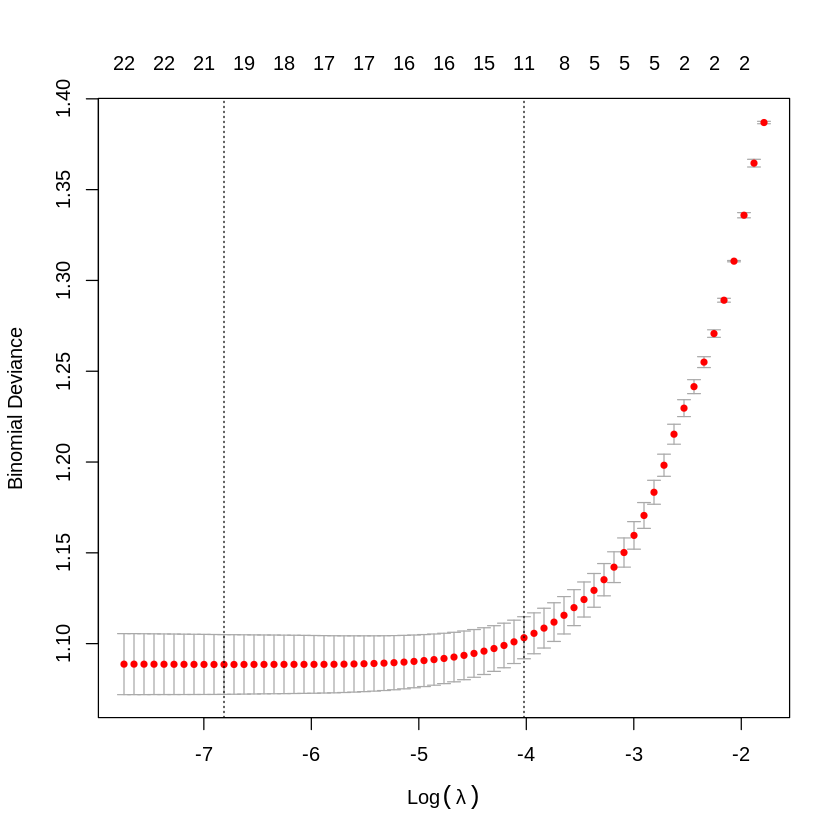

In [73]:
#######################################################################
#                                                                     #
#                   (1) Fit Logistic Regression Model                 #
#                                                                     #
#######################################################################

# Methods 1:  use Lasso and Cross-validation
# X_train2 <- subset(X_train, select = - ind_XYZ) kept to learn coding
x_mtx <- model.matrix( ~.-1, X_train) # create dummy variables/One-hot emcoding for categorical variables; If use ~.-1, to remove intercept
xt_mtx <- model.matrix( ~.-1, X_test)
xv_mtx <- model.matrix( ~.-1, X_val)
#x <- as.matrix(X_trainc)
# cv.glmnet finds the best lambda to minimize cv error first
# then glmnet find the best model coefficients with given lambda to minimize MSE
set.seed(123) 

fraction <- table(y_train)/length(y_train)
# assign 1 - that value to a "weights" vector
model_weights <- 1 - fraction[as.character(y_train)]
# make the model

model_weights <- ifelse(train3$Def_ind == "0",
                        (1-(table(train3$Def_ind)[1]/length(train3$Def_ind))),
                        (1-(table(train3$Def_ind)[2]/length(train3$Def_ind))))

model_weights <- ifelse(train3$Def_ind == "0",
                        (1/table(train3$Def_ind)[1]) * 0.5,
                        (1/table(train3$Def_ind)[2]) * 0.5) # (best, reported online)
#Both above are the same for results
# model_weights (1,4) # tried diff numbers, should not use

set.seed(123) 
# To find best lambda
cv.lasso <- cv.glmnet(x_mtx, factor(y_train), 
    weights = model_weights, intercept=TRUE, alpha = 1, 
    family = "binomial", nfolds=5) 
# alpha=1 is lasso, 0 is ridge, default intercept=TRUE
plot(cv.lasso)
(best_lambda <- cv.lasso$lambda.min)
# or use best_lambda <- cv.lasso$lambda[which.min(cv.lasso$cvm)] # cvm:the mean cross-validation error

# Fit the final model on the training data
model <- glmnet(x_mtx, y_train, alpha = 1, weights = model_weights,
                family = "binomial",
                lambda = best_lambda)
# Display regression coefficients
round(coef(model), 5)


tot_balance                   avg_bal_cards 
                       1.987193                        1.986246 
                     credit_age         credit_age_good_account 
                       5.397348                        2.743174 
                credit_card_age  num_acc_30d_past_due_12_months 
                       3.597421                        3.188927 
  num_acc_30d_past_due_6_months num_mortgage_currently_past_due 
                       3.049310                        3.026203 
  tot_amount_currently_past_due                num_inq_12_month 
                       4.120346                        5.421359 
          num_card_inq_24_month               num_card_12_month 
                       5.416052                        1.015891 
              num_auto_36_month                   uti_open_card 
                       1.014729                        6.164013 
                pct_over_50_uti             uti_max_credit_line 
                       2.284953                        2.314859 
           pct_card_over_50_uti                      rep_income 
                       3.565368                        1.001634

[1] 5.917173

[1] 0.001099976

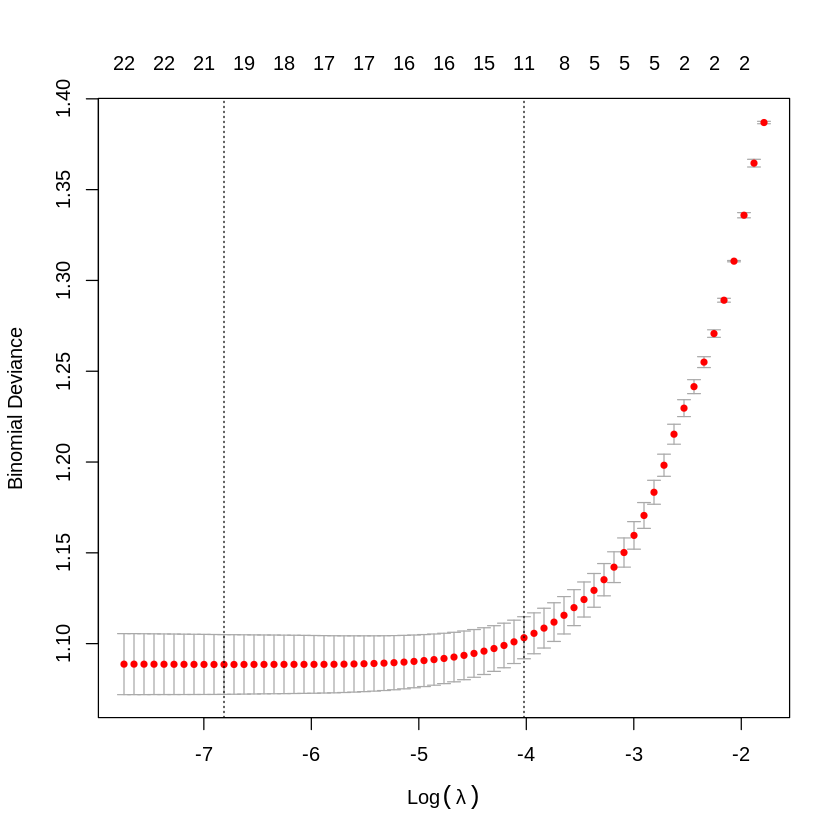

In [52]:


# Method 2: Or use Stepwise model selection with AIC
model_weights <- ifelse(train3$Def_ind == "0", 1, round(table(y_train)[1]/table(y_train)[2]))
model <- glm(Def_ind ~., weights = model_weights, data = train3, family = 'binomial')
summary(model)
step(model) 

# Selected model
model_lr <- glm(Def_ind ~ tot_balance + avg_bal_cards + credit_age + 
                  credit_age_good_account + num_acc_30d_past_due_12_months + 
                  num_acc_30d_past_due_6_months + num_mortgage_currently_past_due + 
                  num_inq_12_month + num_card_inq_24_month + num_card_12_month + 
                  num_auto_36_month + uti_open_card + pct_over_50_uti + uti_max_credit_line + 
                  pct_card_over_50_uti + rep_income + ind_XYZ + rep_education, 
                family = "binomial", data = train3, weights = model_weights) # (final model)

summary(model_lr)
vif(model_lr)

#############################################################
#                                                           #
#           Model Prediction - Logistic Regression          #
#                                                           #
#############################################################

# improved for imbalanced data
#############################################################
pred_train <- predict (model_lr, X_train, type = "response")
pred_val <- predict (model_lr, X_val, type = "response")
pred_tclass <- pred_train
pred_vclass <- pred_val

pred_tclass[pred_tclass >=0.5] <- 1; pred_tclass[pred_tclass <0.5] <- 0
pred_vclass[pred_vclass >=0.5] <- 1; pred_vclass[pred_vclass <0.5] <- 0
confusionMatrix(factor(pred_tclass), factor(y_train), mode = "everything", positive="1") #train
confusionMatrix(factor(pred_vclass), factor(y_val), mode = "everything", positive="1") #validation

# testing sets
pred_test <- predict (model_lr, X_test, type = "response")
pred_class <- pred_test
pred_class[pred_class >=0.23] <- 1;  pred_class[pred_class <0.23] <- 0
# Performance
confusionMatrix(factor(pred_class), factor(y_test), mode = "everything", positive="1")
auc(y_test, pred_test) # AUC
plot(roc(y_test, pred_test), main="ROC curve -- Logistic Regression")
#############################################################

# used with threshold 0.5
#############################################################
pred_train <- predict (model_lr, X_train, type = "response")
pred_val <- predict (model_lr, X_val, type = "response")
pred_tclass <- pred_train
pred_vclass <- pred_val

pred_tclass[pred_tclass >=0.5] <- 1; pred_tclass[pred_tclass <0.5] <- 0
pred_vclass[pred_vclass >=0.5] <- 1; pred_vclass[pred_vclass <0.5] <- 0

# Performance
confusionMatrix(factor(pred_tclass), factor(y_train), mode = "everything", positive="1") #train
confusionMatrix(factor(pred_vclass), factor(y_val), mode = "everything", positive="1") #validation

#############################################################
#                                                           #
#            Performance Report - Logistic Regression       #
#                                                           #
#############################################################

# testing sets
pred_test <- predict (model_lr, X_test, type = "response")
pred_class <- pred_test
pred_class[pred_class >=0.5] <- 1;  pred_class[pred_class <0.5] <- 0
# Performance
confusionMatrix(factor(pred_class), factor(y_test), mode = "everything", positive="1")
auc(y_test, pred_test) # AUC
plot(roc(y_test, pred_test), main="ROC curve -- Logistic Regression")

# Histogram of predictions
data.frame(preds = pred_test) %>%
  ggplot(aes(x = pred_test)) + 
  geom_histogram(bins = 50, fill = 'grey40') +
  labs(title = 'Histogram of Predictions') +
  theme( axis.text=element_text(size=12),
         axis.title=element_text(size=16,face="bold")) 

# Range of predictions
round(range(pred_test),2)
# Median of predictions
median(pred_test)

#######################################################################
#                                                                     #
#                    (2) Fit Random Forest Model                      #
#                                                                     #
#######################################################################

#Sys.setenv(JAVA_HOME="C:\\Program Files\\Java\\jdk1.8.0_25\\jre")
#Sys.getenv("JAVA_HOME")

# Fit all features
predictor <- train3[,-21]
y_train <- factor(y_train)
model_rf <- randomForest(predictor, y_train, mtry=5, ntree=101, importance=TRUE) 
model_rf
plot(model_rf)

#############################################################
#                                                           #
#            Select Features Based on Importance            #
#                                                           #
#############################################################

# Importance of features
imp <- importance(model_rf) %>% data.frame() %>% mutate(feature = row.names(.)) 
imp_dsc <- imp[order(imp$MeanDecreaseAccuracy, decreasing = TRUE),]
imp_dsc

importance <- importance(model_rf) 
# Create data frame using importance. 
varImportance <- data.frame(Variables = row.names(importance), 
                            Importance = round(importance[,'MeanDecreaseAccuracy'], 0))
varImportance <- varImportance[order(varImportance$Importance, decreasing = TRUE),]
varImportance
# Create interactive plot.  
ggplot(varImportance, aes(x = reorder(Variables, Importance), 
                          y = Importance, fill = Importance)) +
  geom_bar(stat='identity') + 
  labs(title = 'Importance of predictors', x = 'Predictors', y = 'rmsle') +
  coord_flip() + 
  theme_light()

# Features selection
features <- varImportance$Variables[varImportance$Importance > 10]
length(features)
features

# For comparison with logistic regression-9 features
# features <- varImportance$Variables[varImportance$Importance > 15]
# length(features)
#features

predictor_train <- train3[,which(names(train3) %in% features)]
predictor_val <- val3[,which(names(val3) %in% features)]
predictor_test <- test3[,which(names(test3) %in% features)]

# Fit model 
model_rf2 <- randomForest(predictor_train, y_train,sampsize =0.01*length(y_train), 
                          mtry=8, ntree=1501, importance=TRUE) 
model_rf2 
getTree(model_rf2, 1, labelVar=TRUE)
plot(model_rf2,log="x",main="black default, red samplesize, green tree depth")

#############################################################
#                                                           #
#            Prediction on data - Random Forest             #
#                                                           #
#############################################################

# Model Prediction
pred_train <- predict(model_rf2, predictor_train, type = "prob")
pred_val <- predict(model_rf2, predictor_val, type = "prob")

# Validate - performance
pred_tclass <- pred_train[,2]
pred_vclass <- pred_val[,2]
pred_tclass[pred_tclass >=0.5] <- 1;  pred_tclass[pred_tclass <0.5] <- 0
pred_vclass[pred_vclass >=0.5] <- 1;  pred_vclass[pred_vclass <0.5] <- 0

confusionMatrix(factor(pred_tclass), factor(y_train), mode = "everything", positive="1")
confusionMatrix(factor(pred_vclass), factor(y_val), mode = "everything", positive="1")
auc(y_train, pred_train[,2]) # AUC
auc(y_val, pred_val[,2]) # AUC

#library(pROC)
plot(roc(y_train, pred_train[,2]), main="ROC curve -- Random Forest ")
plot(roc(y_val, pred_val[,2]), main="ROC curve -- Random Forest")

#############################################################
#                                                           #
#              Model Performance - Random Forest            #
#                                                           #
#############################################################

pred_test <- predict(model_rf2, predictor_test, type = "prob")
pred_class <- pred_test[,2]
pred_class[pred_class >=0.5] <- 1;  pred_class[pred_class <0.5] <- 0

# Report Performance
confusionMatrix(factor(pred_class), factor(y_test), mode = "everything", positive="1")
auc(y_test, pred_test[,2]) # AUC
plot(roc(y_test, pred_test[,2]), main="ROC curve -- Random Forest")

# Histogram of predictions
data.frame(preds = pred_test[,2]) %>%
  ggplot(aes(x = pred_test[,2])) + 
  geom_histogram(bins = 50, fill = 'grey40') +
  labs(title = 'Histogram of Predictions') +
  theme_bw()

# Range of predictions
round(range(pred_test[,2]),2)
# Median of predictions
median(pred_test[,2])

#######################################################################
#                                                                     #
#                             (3) XGBoost                             #
#                                                                     #
#######################################################################

# One-hot emcoding
dummy <- dummyVars(" ~ .", data=X_train)
X_trainc <- data.frame(predict(dummy, newdata = X_train))
dummy <- dummyVars(" ~ .", data=X_val)
X_valc <- data.frame(predict(dummy, newdata = X_val))
dummy <- dummyVars(" ~ .", data=X_test)
X_testc <- data.frame(predict(dummy, newdata = X_test))

#############################################################
#                                                           #
#                        PCA (Optional)                     #
#                                                           #
#############################################################
train3$rep_education <- factor(train3$rep_education)
sparse_matrix <- sparse.model.matrix(Def_ind~.-1, data = train3)
output_vector = train3$Def_ind
sparse_matrixt <- sparse.model.matrix(Def_ind~.-1, data = val3)
output_vectort = val3$Def_ind

# PCA scaling the x variables
pca <- prcomp (X_trainc, center = TRUE, scale = TRUE)
plot((pca$sdev)^2, type ="b")
pca$rotation
barplot((pca$sdev)^2/(sum((pca$sdev)^2))*100) # variance
X_trainc <- pca$x[,1:12]

# plot(X_trainc$x[,1],X_trainc$x[,2])
# X_trainc$x
X_valc <- predict(pca, newdata = X_valc)
X_valc <- X_valc[, 1:12]

X_testc <- predict(pca, newdata = X_testc)
X_testc <- X_testc [, 1:12]

#############################################################
#                                                           #
#                     Fit XGBoost Model                     #
#                                                           #
#############################################################

# Define train, validation, test data
y_train <- train3$Def_ind
y_val <- as.numeric(y_val)
y_test <- as.numeric(y_test)

dtrain = xgb.DMatrix(data = as.matrix(X_trainc), label = y_train)
dval = xgb.DMatrix(data = as.matrix(X_valc), label = y_val)
dtest = xgb.DMatrix(data = as.matrix(X_testc), label = y_test)

# define watchlist
watchlist = list(train = dtrain, validation = dval)

# Tuning the model

# negative & positive cases in the data
negative_cases <- sum(y_train == 0)
postive_cases <- sum(y_train == 1)

# set XGB parameters 
param <- list(  objective           = "binary:logistic", 
                booster             = "gbtree",
                eval_metric         = "auc",
                eta                 = 0.02,     
                max_depth           = 2,       
                subsample           = 0.95,     
                colsample_bytree    = 0.3,       
                min_child_weight    = 2,    
                num_parallel_tree   = 1        
)

nrounds <- 1500
early.stop.round <- 50

# Fit and tune XGB model
model <- xgb.train( params              = param, 
                    data                = dtrain, 
                    nrounds             = nrounds, 
                    verbose             = 1,
                    print_every_n       = 100,
                    early_stopping_rounds = early.stop.round,
                    #scale_pos_weight = 0.35*(negative_cases/postive_cases),or
                    #scale_pos_weight = sqrt(negative_cases/postive_cases)
                    # VIP: use grid search, google article
                    #or alter threshold
                    watchlist           = watchlist,
                    maximize            = TRUE)

#############################################################
#                                                           #
#               Study Individual Variable Effect            #
#                                                           #
############################################################# 
# method 1: PDP plots for effects of individual variable/partial dependence plot
# pd2 <- partial(model, pred.var = c("uti_open_card", "num_card_inq_24_month"), plot =FALSE, prob= TRUE, train = X_trainc)
partial(model, pred.var = c("ind_XYZ.1"), plot =T, prob= T, train = X_trainc)

pd <- partial(model, pred.var = "ind_XYZ.1", plot = FALSE,prob= T, train = X_trainc)
head(pd)
plot(pd)

library(ggplot2)
p2 <- autoplot(pd, contour = TRUE, main = "ggplot2 version", 
               legend.title = "Partial\ndependence")
p2

# method 2 to show single effect: SHAP plots for effects of individual variable
# Step 1: Select some observations
X <- data.matrix(X_trainc[sample(nrow(X_trainc), 1000), ]) ###
X
# Step 2: Crunch SHAP values
shap <- shap.prep(model, X_train = X)

# Step 3: SHAP importance
shap.plot.summary(shap)

# Step 4: Loop over dependence plots in decreasing importance
for (v in shap.importance(shap, names_only = TRUE)) {
  p <- shap.plot.dependence(shap, v, color_feature = "auto", 
                            alpha = 0.5, jitter_width = 0.1) +
    ggtitle(v)
  print(p)
}

# hyperparameters
inputs <- c("nrounds"=model$bestInd,
            "eta"=param$eta,
            "max_depth"=param$max_depth,
            "subsample"=param$subsample,
            "colsample_bytree"=param$colsample_bytree,
            "min_child_weight"=param$min_child_weight,
            "num_parallel_tree"=param$num_parallel_tree)
inputs

# Prediction on training set
pred_train <- predict(model,dtrain)
pred_tclass <- pred_train

pred_tclass[pred_tclass >=0.5] <- 1;  pred_tclass[pred_tclass <0.5] <- 0
confusionMatrix(factor(pred_tclass), factor(y_train), mode = "everything", positive="1")
auc(y_train, pred_train)

# Prediction on validation set
pred_val <- predict(model,dval)
pred_vclass <- pred_val
pred_vclass[pred_vclass >=0.5] <- 1;  pred_vclass[pred_vclass <0.5] <- 0
confusionMatrix(factor(pred_vclass), factor(y_val), mode = "everything", positive="1")
auc(y_val, pred_val)

# prediction on test set - performance report 
pred_test <- predict(model,dtest)
pred_tclass <- pred_test
pred_tclass[pred_tclass >=0.5] <- 1;  pred_tclass[pred_tclass <0.5] <- 0
confusionMatrix(factor(pred_tclass), factor(y_test), mode = "everything", positive="1")
auc(y_test, pred_test)
plot(roc(y_test, pred_test), main="ROC curve -- Xgboost")

# Show one of the trees
xgb.plot.multi.trees(feature_names = names(data.matrix(X_trainc)),
                     model = model)


# convert log odds to probability
odds_to_probs <- function(odds){
  return(exp(odds)/ (1 + exp(odds)))
}

# e.g. prob of being in class 1 if directed to the top leaf
odds_to_probs(0.18222)  # = 0.545

# Importance of features
imp <- xgb.importance(model = model)
imp
ggplot(imp, aes(x = reorder(Feature, Gain), 
                y = Gain, fill = Gain)) +
  geom_bar(stat='identity') + 
  labs(title = 'Importance of features', x = 'Features', y = 'Gain') +
  coord_flip() + 
  theme_light()


# Histogram of predictions
data.frame(preds = pred_test) %>%
  ggplot(aes(x = pred_test)) + 
  geom_histogram(bins = 50, fill = 'grey40') +
  labs(title = 'Histogram of Predictions') +
  theme_bw()

# Range of predictions
round(range(pred_test),2)
# Median of predictions
median(pred_test)



In [67]:
# Make predictions on the validation data
probabilities_val <- model %>% predict(s='lambda.min', newx = xv_mtx, type="response")
predicted.classes_val <- ifelse(probabilities_val >= 0.5, 1, 0)
length(probabilities_val)
length(predicted.classes_val)
length(y_val)
# Model accuracy
observed.classes_val <- y_test
confusionMatrix(factor(predicted.classes_val), factor(y_val), mode = "everything", positive="1")



[1] 3999

[1] 3999

[1] 4000

ERROR: ignored

In [ ]:
auc(y_val, as.vector(probabilities_val))# AUC
plot(roc(y_val, probabilities_val), main="ROC curve -- Logistic Regression")

In [ ]:

# Make predictions on the test data
probabilities <- model %>% predict(s='lambda.min', newx = xt_mtx, type="response")
predicted.classes <- ifelse(probabilities >= 0.5, 1, 0)
# Model accuracy
observed.classes <- y_test
confusionMatrix(factor(predicted.classes), factor(y_test), mode = "everything", positive="1")
auc(y_test, as.vector(probabilities))# AUC
plot(roc(y_test, probabilities), main="ROC curve -- Logistic Regression")



In [2]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



**Example**  Johnson & Johnson Quarterly Earnings

In [ ]:
jj

In [ ]:
class(jj)
typeof(jj)

[1] "ts"

[1] "double"

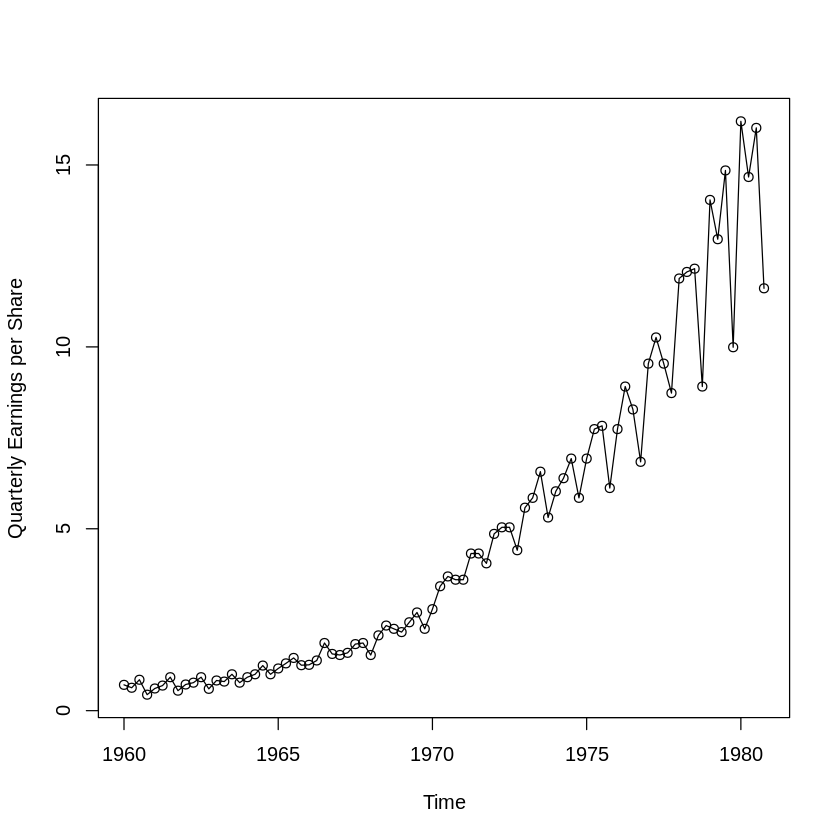

In [ ]:
plot(jj, type="o", ylab="Quarterly Earnings per Share")

**Note**: there is no data between discrete time points. 
People usually   connect the values at adjacent time periods to
reconstruct visually a hypothetical continuously evolving time series.

Observations: 
*   Trend
*   Cycle



 

Questions we can ask:


*   Predict next quarter earning.
*   Find external factors that explain earning fluctuation


...


**Example** Global Warming

The data are the
global mean land–ocean temperature index from 1880 to 2015, with the base period
1951-1980. In particular, the data are deviations, measured in degrees centigrade,
from the 1951-1980 average.

In [ ]:
globtemp

A Time Series:
  [1] -0.20 -0.11 -0.10 -0.20 -0.28 -0.31 -0.30 -0.33 -0.20 -0.11 -0.37 -0.24
 [13] -0.27 -0.30 -0.31 -0.22 -0.15 -0.11 -0.28 -0.16 -0.09 -0.15 -0.28 -0.36
 [25] -0.45 -0.28 -0.23 -0.40 -0.44 -0.47 -0.43 -0.44 -0.35 -0.35 -0.16 -0.11
 [37] -0.33 -0.40 -0.26 -0.23 -0.26 -0.21 -0.27 -0.24 -0.28 -0.20 -0.09 -0.20
 [49] -0.21 -0.36 -0.13 -0.09 -0.17 -0.28 -0.13 -0.19 -0.15 -0.02 -0.02 -0.03
 [61]  0.08  0.13  0.10  0.14  0.26  0.12 -0.03 -0.04 -0.09 -0.09 -0.17 -0.06
 [73]  0.01  0.08 -0.12 -0.14 -0.20  0.03  0.06  0.03 -0.03  0.05  0.02  0.06
 [85] -0.20 -0.10 -0.05 -0.02 -0.07  0.07  0.03 -0.09  0.01  0.15 -0.08 -0.01
 [97] -0.11  0.18  0.07  0.16  0.27  0.32  0.13  0.31  0.16  0.12  0.19  0.33
[109]  0.40  0.28  0.44  0.42  0.23  0.24  0.32  0.46  0.34  0.48  0.63  0.42
[121]  0.42  0.55  0.63  0.62  0.55  0.69  0.63  0.66  0.54  0.64  0.72  0.60
[133]  0.63  0.66  0.75  0.87

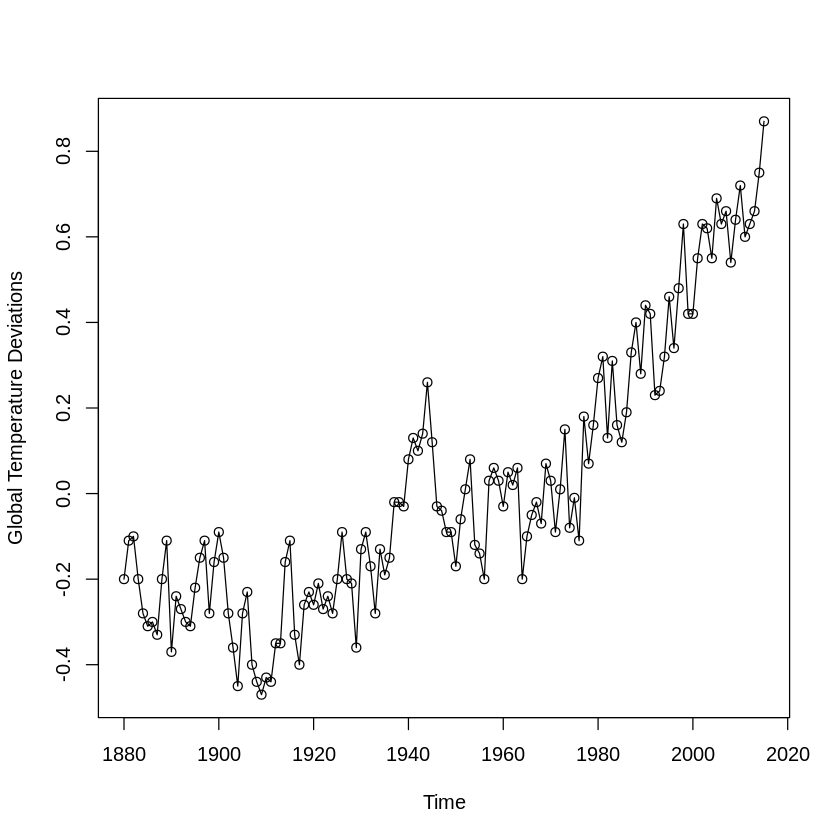

In [ ]:
plot(globtemp, type="o", ylab="Global Temperature Deviations")

Observations



*   Irregular (random) fluctuation
*   Potential trend?



Questions we can ask:


*   Is there a breakpoint (or multiple ones) in the trend? $\Rightarrow$ Global warming?


(Topic: [Change Point Detection](https://en.wikipedia.org/wiki/Change_detection)).

...

 



**Example**: Speech Signal

100ms-frequency  sample of recorded speech for
the phrase   aaa $\cdots$ hhh.

In [ ]:
speech

A Time Series:
   [1] 1814 1556 1442 1416 1352 1154  974  962 1040 1205 1324 1287 1095  840
  [15]  725  854 1176 1670 2528 3870 4095 4095 4095 3934 3151 2334 1664 1044
  [29]  474  175  151  339  702 1224 1866 2545 2970 2945 2648 2354 2105 1865
  [43] 1734 1665 1590 1604 1708 1870 2082 2349 2583 2769 2894 2858 2723 2611
  [57] 2530 2452 2346 2212 2084 2002 2104 2331 2646 2916 3060 2872 2440 2254
  [71] 2294 2486 2588 2566 2360 2144 2030 2039 2201 2486 2688 2487 2109 1820
  [85] 1707 1775 2014 2343 2422 2181 1876 1675 1634 1742 1856 1883 1776 1646
  [99] 1619 1727 1952 2189 2304 2199 1951 1687 1489 1346 1315 1414 1508 1464
 [113] 1498 1566 1481 1285 1116  944  946 1199 1630 2201 3059 4062 4095 4094
 [127] 3593 2941 2245 1702 1220  783  578  563  665  933 1463 2110 2650 3000
 [141] 3045 2763 2372 2062 1802 1594 1467 1389 1354 1391 1532 1777 2068 2360
 [155] 2645 2790 2752 2625 2494 2357 2225 2091 1981 1915 1828 1800 1901 2068
 [169] 2333 2672 2963 2927 2637 2296 2086 2164 2335 2413 2345 2251 2120 2026
 [183] 2088 2251 2494 2603 2445 2138 1919 1893 1972 2174 2459 2499 2265 1922
 [197] 1661 1574 1660 1833 1922 1931 1886 1878 1957 2112 2256 2213 2061 1845
 [211] 1678 1532 1413 1349 1433 1586 1694 1724 1639 1409 1170  985  921 1163
 [225] 1665 2335 3182 4095 4095 3992 3417 2713 2083 1671 1274  810  524  436
 [239]  550  832 1367 2117 2693 2894 2887 2653 2379 2178 1999 1835 1683 1540
 [253] 1477 1524 1681 1915 2231 2511 2675 2722 2687 2620 2550 2514 2426 2281
 [267] 2161 2084 2066 2095 2145 2205 2217 2267 2375 2594 2771 2892 2918 2620
 [281] 2236 2016 1985 2048 2134 2186 2141 2105 2079 2108 2211 2349 2430 2332
 [295] 2131 1946 1858 1847 1913 2028 2048 1942 1807 1736 1751 1824 1899 1977
 [309] 1989 2027 2157 2265 2279 2194 2047 1821 1644 1519 1403 1355 1473 1596
 [323] 1622 1568 1512 1407 1327 1198 1135 1310 1683 2173 2832 3740 4037 3767
 [337] 3317 2770 2212 1748 1388 1042  820  804  945 1227 1701 2284 2698 2867
 [351] 2854 2653 2398 2204 1988 1770 1592 1444 1331 1365 1524 1755 2032 2309
 [365] 2496 2549 2484 2412 2354 2315 2247 2129 2008 1896 1899 1947 2026 2091
 [379] 2099 2116 2194 2305 2450 2626 2792 2686 2427 2114 1974 2024 2134 2172
 [393] 2142 2133 2098 2081 2134 2258 2370 2324 2199 2075 1990 1956 1947 1978
 [407] 2032 2012 1957 1899 1895 1902 1912 1938 1958 1986 2064 2247 2362 2328
 [421] 2173 1935 1762 1685 1661 1656 1660 1666 1635 1592 1582 1576 1566 1430
 [435] 1225 1144 1324 1754 2343 3147 3874 3961 3607 3123 2572 2116 1844 1525
 [449] 1069  769  747  907 1222 1745 2381 2778 2918 2821 2584 2419 2304 2155
 [463] 1933 1697 1472 1314 1354 1540 1811 2087 2336 2462 2459 2428 2389 2400
 [477] 2437 2387 2210 2035 1923 1880 1924 2012 2102 2129 2088 2095 2231 2485
 [491] 2704 2834 2772 2535 2213 1930 1805 1892 2103 2171 2055 2048 2095 2108
 [505] 2192 2419 2554 2454 2166 1888 1761 1765 1854 1937 2050 2062 1951 1832
 [519] 1814 1874 1924 1957 1964 2027 2151 2234 2167 2004 1930 1882 1790 1702
 [533] 1651 1577 1492 1459 1525 1600 1660 1639 1468 1200 1110 1382 1898 2548
 [547] 3384 4080 4032 3531 3027 2624 2317 2013 1532  935  606  621  860 1296
 [561] 1939 2536 2690 2632 2564 2485 2537 2584 2370 1975 1567 1296 1197 1316
 [575] 1570 1860 2103 2196 2235 2312 2429 2565 2639 2602 2419 2172 1998 1910
 [589] 1938 2004 2077 2122 2139 2124 2110 2073 2073 2228 2593 2794 2655 2462
 [603] 2252 1901 1807 1958 2242 2327 2157 1958 1908 1965 2123 2359 2631 2744
 [617] 2419 2023 1827 1807 1817 1819 1826 1783 1739 1719 1756 1875 2027 2093
 [631] 2058 2021 2038 2121 2202 2068 1883 1764 1701 1654 1652 1660 1630 1548
 [645] 1529 1615 1679 1678 1569 1375 1263 1365 1647 2091 2642 3304 3671 3658
 [659] 3408 3064 2798 2524 2067 1478 1072  918  957 1200 1619 2086 2400 2473
 [673] 2472 2428 2476 2597 2512 2240 1900 1616 1453 1446 1602 1767 1879 1976
 [687] 2067 2132 2224 2386 2500 2470 2330 2134 1978 1881 1876 1913 1955 1951
 [701] 1963 1995 2025 2083 2292 2579 2658 2541 2370 2168 2043 2107 2192 2206
 [715] 2141 2019 1912 1932 2079 2180 2251 2274 2207 2077 2

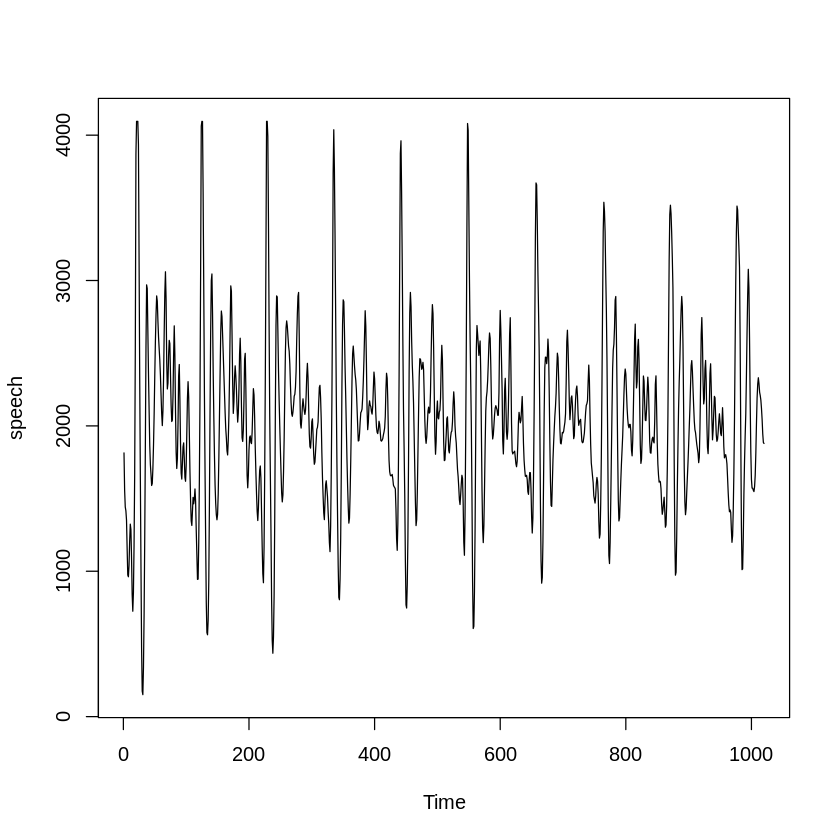

In [ ]:
plot(speech)

Observations



*   Regular repetition of cycles (*pitch periods*).
*   Amplitude changes over time while cyclic pattern is relatively stable.




Questions we can ask:



*   How can one recognize pattern in frequency domain?

(Topic: [Spectral Analysis](https://en.wikipedia.org/wiki/Spectral_analysis))

<br>

Our course will NOT go deep into analysis of regular cyclic time series (specially the ones with large-sample  and high-frequency). E.g., electric/sound/light signals. 

Refer to the subject [Signal Processesing](https://en.wikipedia.org/wiki/Signal_processing)



<br>

Statistical time series analysis emphasizes on analysis of time series *exhibiting irregular fluctuations* (in general, statistics is a subject dealing with noisy data).


 



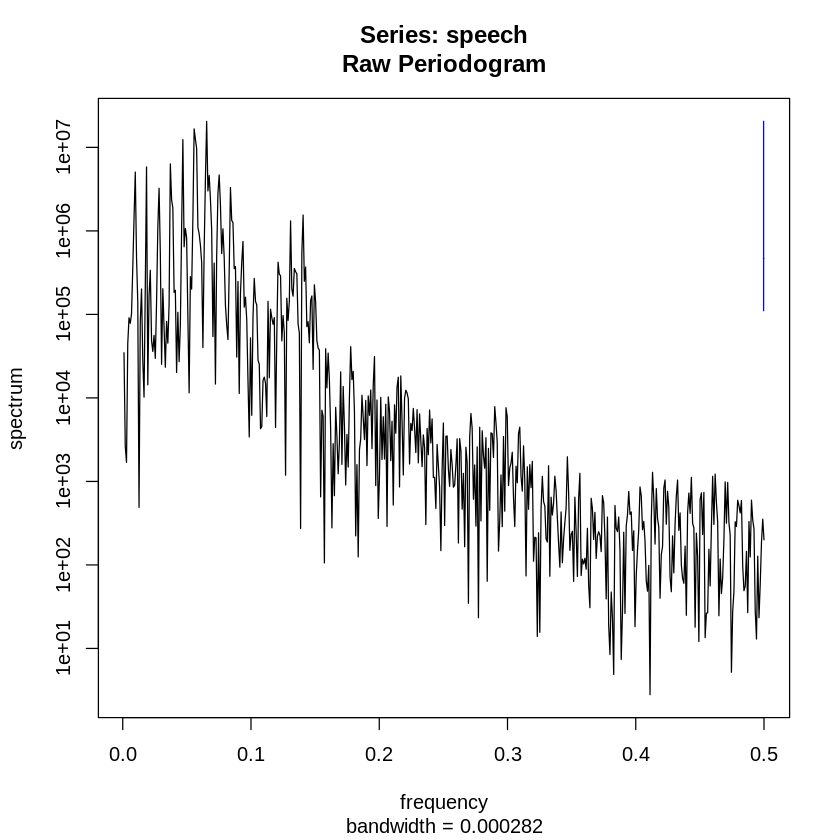

In [ ]:
spec.pgram(speech) # wait until Chapter 4 to see

**Example**: Dow Jones Industrial Average



In [ ]:
install.packages("xts");library(xts)  

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




               Open     High      Low    Close    Volume
2006-04-20 11278.53 11384.11 11275.05 11342.89 336420000
2006-04-21 11343.45 11405.88 11316.79 11347.45 325090000
2006-04-24 11346.81 11359.70 11305.83 11336.32 232000000
2006-04-25 11336.56 11355.37 11260.84 11283.25 289230000
2006-04-26 11283.25 11379.87 11282.77 11354.49 270270000
2006-04-27 11349.53 11416.93 11275.30 11382.51 361740000
2006-04-28 11358.33 11417.66 11347.21 11367.14 738440000
2006-05-01 11367.78 11428.37 11329.44 11343.29 365970000
2006-05-02 11345.21 11427.65 11345.13 11416.45 335420000
2006-05-03 11414.69 11424.93 11362.42 11400.28 380540000

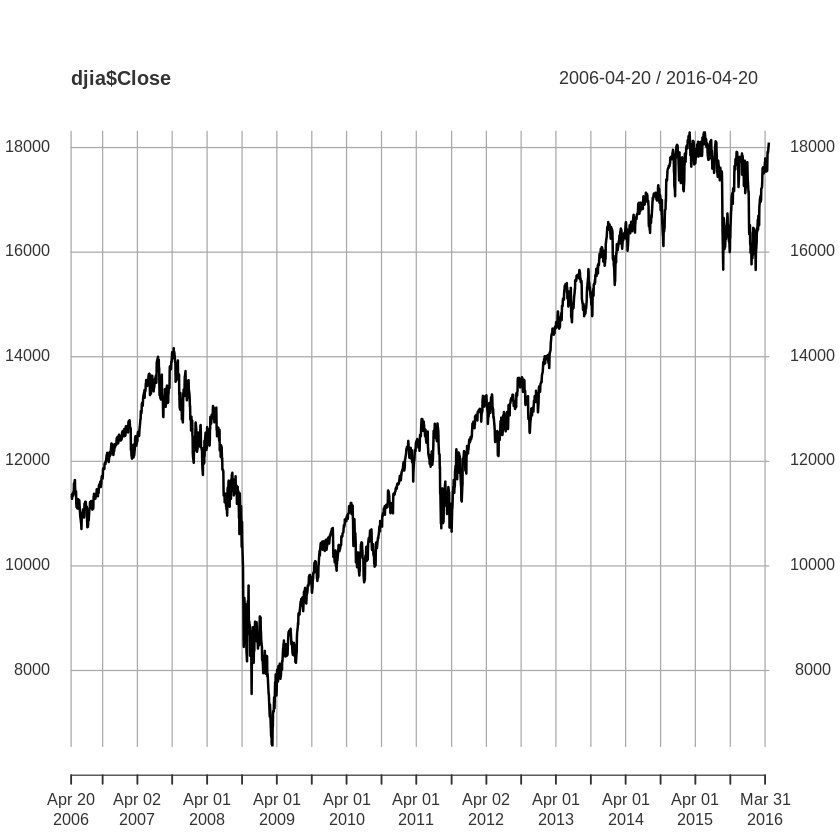

In [ ]:
head(djia,10) # first 10 rows of data
plot(djia$Close)

Suppose $x_t$ is the closing price at $t$th day.

However, people are usually more interested in the relative price change:

$\tilde{r}_t= \frac{x_t-x_{t-1}}{x_{t-1}}$.

In finance, people also look at a quantity called *log return*:

$r_t=\log(x_t/x_{t-1})=\log(x_t)-\log(x_{t-1})=\log\left(1+ \frac{x_t-x_{t-1}}{x_{t-1}} \right)\approx \tilde{r}_t$.

Fact: $\log(1+y)\approx y$ when $|y|$ is small.


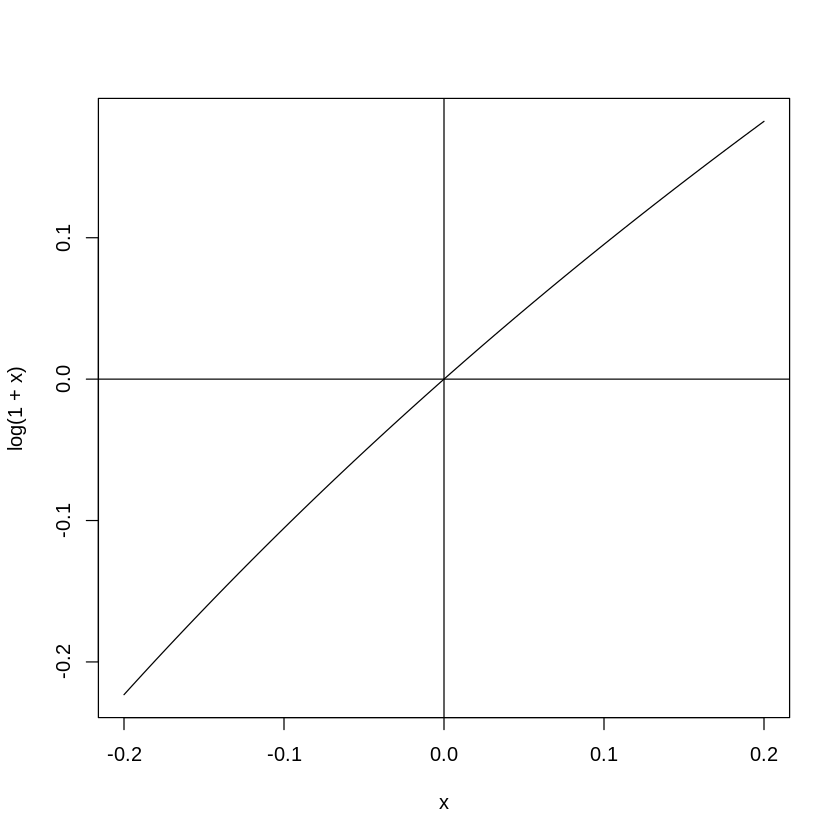

In [ ]:
curve(log(1+x),-0.2,0.2) #plot log(1+x) function
abline(h=0, v=0)#plot x-y axes 

**Definition**  The operation $(x_1,x_2,\ldots,x_n)\rightarrow (x_{\ell+1}-x_{1}, x_{\ell+2}-x_2,\ldots, x_{n}-x_{n-\ell+1})$ is called differencing, where $\ell=1,2,3,\ldots$ is called the *lag*. We take the lag $\ell=1$ by default if not specified otherwise.
 
In R it can be achieved with [diff](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/ts-methods) function.

In [ ]:
x<-c(1,3,5,7,9)
(diff(x))
(y<-diff(x,lag=2))

[1] 2 2 2 2

[1] 4 4 4

We first plot the log-transformed closing price.

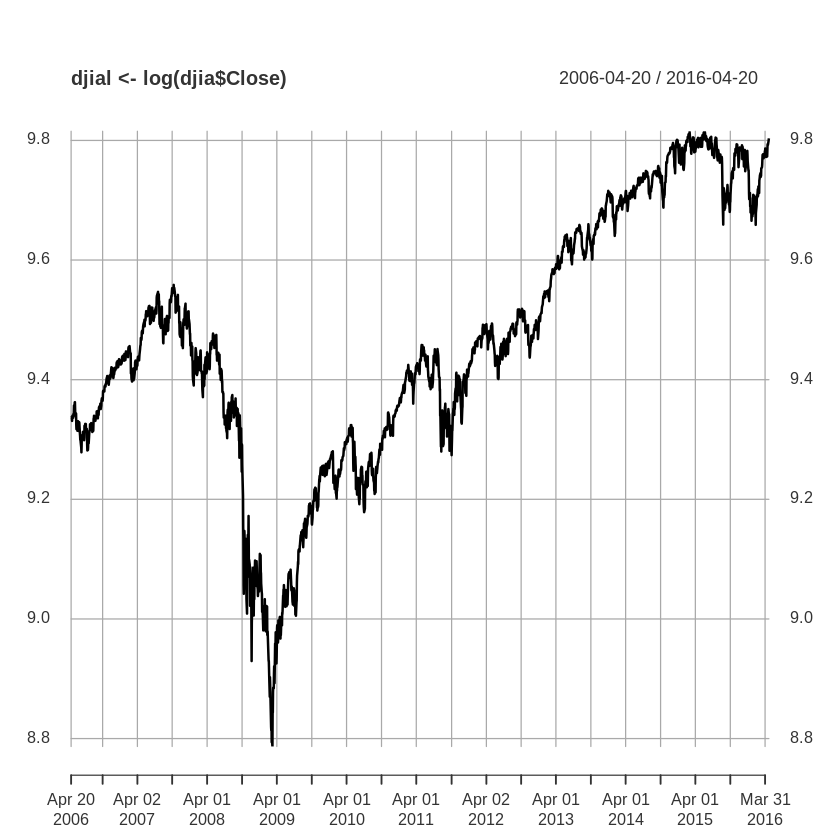

In [ ]:
plot(djial<-log(djia$Close))

Log return can be obtained by first take log elementwise and then perform  differencing (lag=1).

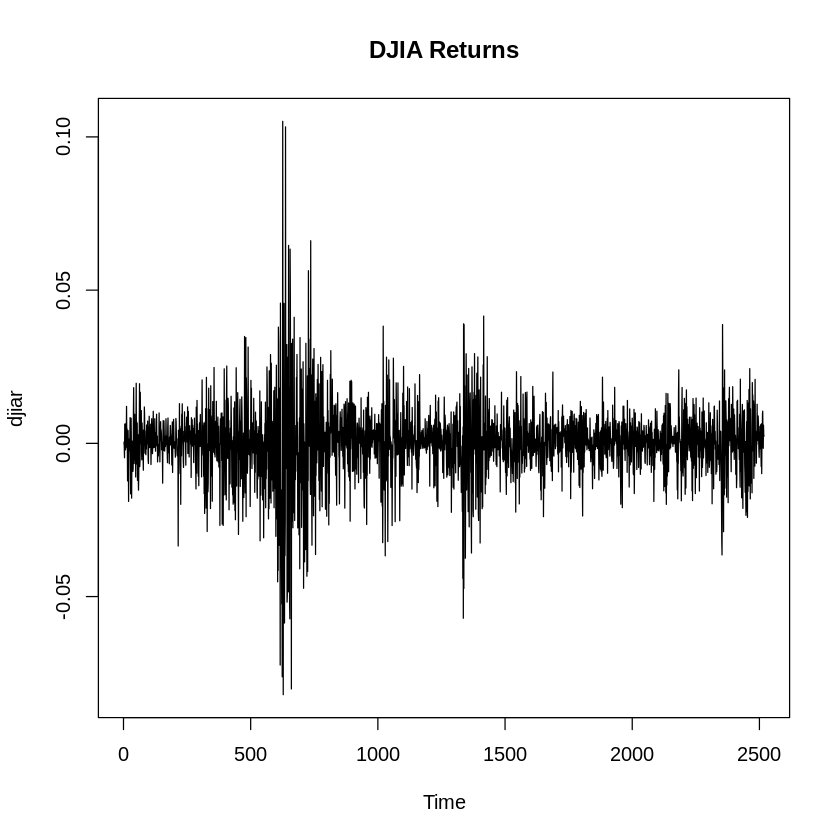

In [ ]:
djiar = diff(as.ts(djial))  #log return
plot(djiar, main="DJIA Returns")

Observations



*  Clustering of fluctuation magnitude (volatility clustering)
   



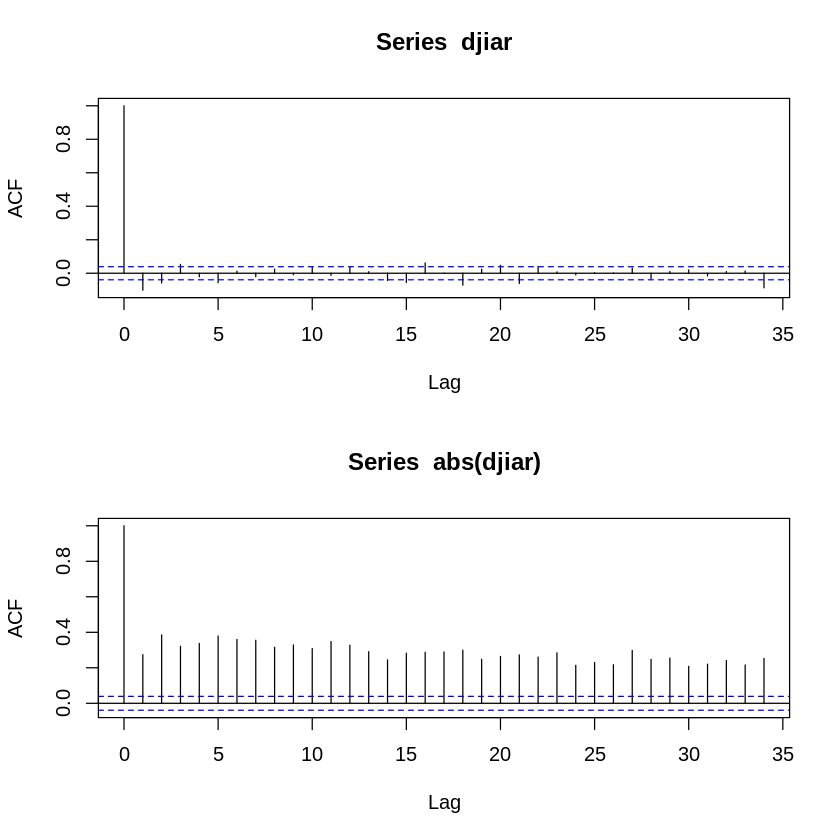

In [ ]:
par(mfrow = c(2,1)) # set up the graphics
acf(djiar) # compute & plot sample auto-correlation function (will elaborate later)
acf(abs(djiar)) 

Check "GARCH" models.

**Example** El Niño and Fish Population 

Monthly values of an environmental series called the Southern Oscillation
Index (*SOI*, changes in air pressure) and associated *Recruitment* (number of new fish)



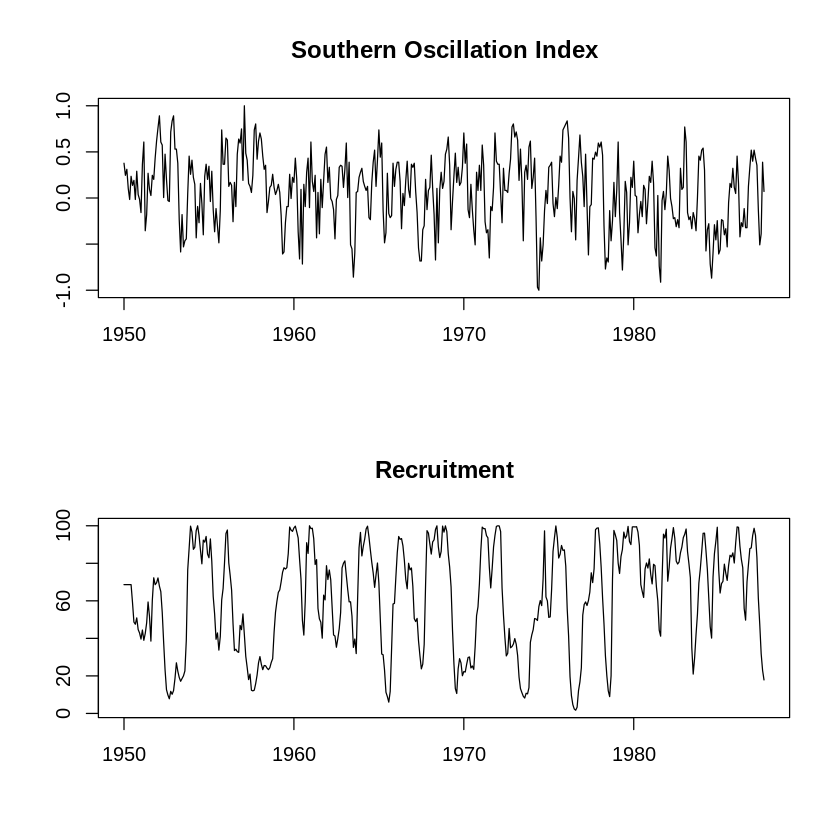

In [ ]:
par(mfrow = c(2,1))  
plot(soi, ylab="", xlab="", main="Southern Oscillation Index")
plot(rec, ylab="", xlab="", main="Recruitment")

Observations


*    Both  collected at the same time points.
*    Annual cycle and   4-year cycle.
*    Two series are related.



Questions we can ask:


*   Are the cycles changing over time?
*   Joint analysis of two time series. E.g., do  SOI and Recruitment have a causal relationship?  

Time-Frequency Analysis (e.g., [Wavelet](https://en.wikipedia.org/wiki/Wavelet))

Causal analysis (e.g., [Granger Causality](https://en.wikipedia.org/wiki/Granger_causality))
 



Exercise 6. Plot multiple time series in a single graph.